## **Time Series: LSTM**

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
from google.colab import files
import io

from __future__ import print_function
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import optimizers

In [4]:
uploaded = files.upload()

Saving beacon_data.csv to beacon_data.csv


In [5]:
data = pd.read_csv(io.BytesIO(uploaded["beacon_data.csv"]),sep = ';') #read the .csv file

In [6]:
data.head()

,id,gtid,vendor_id,subscriber_id,merchant_id,signal_type,entry_date,exit_date,latitude,longitude,dongle_id,distance,proximity,rssi
0,2339839562,F9341167-6D6C-4321-924F-2E6B9D9CEF7A,135,29253903,2133,2,2017-05-01 09:54:14.000000,NaN,40.992124,29.126770,5536,-100.000000,unknown,0.0
1,2340151194,EB93B8DF-1F8D-4BD6-A4E5-67B9BACBF6CF,135,17090954,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
2,2340151210,5563AB7A-C5B0-492D-80E5-04E52A5C0C28,135,17090954,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
3,2340151187,55AFD11A-06A3-4E9D-8735-445F3DE654D7,178,15630196,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
4,2340185826,52DE3BD3-655B-40F2-AC37-1199E0CBD31B,178,15630196,2133,2,2017-05-01 10:32:19.000000,NaN,40.992110,29.126783,5536,1467.799268,far,-85.0


## **Step 1: Check if the columns have NA values**

In [7]:
for column in data:
    print(column +' '+ str(data[column].isnull().values.any()) +' '+str(sum(data[column].isnull())/len(data)))

id False 0.0
gtid False 0.0
vendor_id False 0.0
subscriber_id False 0.0
merchant_id False 0.0
signal_type False 0.0
entry_date False 0.0
exit_date True 0.8725349301397206
latitude True 0.00775249500998004
longitude True 0.00775249500998004
dongle_id False 0.0
distance True 0.12746506986027945
proximity True 0.12746506986027945
rssi True 0.12746506986027945


### ***Step 1.1: Then I removed some variables***

In [8]:
data = data.drop("id",axis = 1) # choose variable id or gtid. Both are almost similar.
data = data.drop("merchant_id",axis = 1) # unique ID
data = data.drop("dongle_id",axis = 1) # unique ID
data = data.drop("exit_date",axis = 1) # entry_date = exit_date when signal = 4
data = data.drop("rssi",axis = 1)

## **Step 2: Removed all the repeated values. Just 4.6% of rows are repeated**

In [9]:
### 2. Find duplicated values using columns from vendor_id 
# I removed all the repeated values that I found

duplicated_values = data.iloc[:,1:len(data.columns)].duplicated() #there are duplicated values
sum(duplicated_values)/len(duplicated_values) # 4.6% of the rows are duplicated.
data = data[duplicated_values == False] # removed the duplicated rows

In [10]:
data.head()

,gtid,vendor_id,subscriber_id,signal_type,entry_date,latitude,longitude,distance,proximity
0,F9341167-6D6C-4321-924F-2E6B9D9CEF7A,135,29253903,2,2017-05-01 09:54:14.000000,40.992124,29.126770,-100.000000,unknown
1,EB93B8DF-1F8D-4BD6-A4E5-67B9BACBF6CF,135,17090954,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far
3,55AFD11A-06A3-4E9D-8735-445F3DE654D7,178,15630196,2,2017-05-01 10:28:45.000000,40.992183,29.126761,1668.100537,far
4,52DE3BD3-655B-40F2-AC37-1199E0CBD31B,178,15630196,2,2017-05-01 10:32:19.000000,40.992110,29.126783,1467.799268,far
5,EDDB06CB-686C-4DE5-9662-7798E9FD389A,135,17090954,2,2017-05-01 10:33:24.000000,40.992189,29.126786,1042.299640,far


## **Step 3: Modify dates and removed latitude and longitude**

In [11]:
data_1 = data[data["proximity"] != "unknown"] #Removed unknown records
data_1 = data_1.drop(["latitude","longitude"],axis = 1)  #Removed latitud and longitude
data_1 = data_1.sort_values(by = ["subscriber_id","entry_date"], ascending = True) #Sort values by subscriber_id and entry_date
data_1["entry_date"] = pd.to_datetime(data_1["entry_date"]) 
data_1["day_entry_date"] = [d.date() for d in data_1["entry_date"]]

In [12]:
data_1.head()

,gtid,vendor_id,subscriber_id,signal_type,entry_date,distance,proximity,day_entry_date
80318,63C75856-B672-4175-9CAA-EF1A26A06814,6,26992,2,2017-07-29 15:51:08,1807.501630,far,2017-07-29
80836,91A411BF-6FE5-4E41-ACDC-85D1825D197A,6,26992,2,2017-07-29 15:51:48,2017.969873,far,2017-07-29
83933,E3BE7BF7-2583-48E1-A5B8-9013F77FE63E,6,26992,2,2017-07-29 15:54:46,681.292069,far,2017-07-29
80322,22D56BAA-AEB2-4796-8B2D-AEB44CF83CF8,6,26992,2,2017-07-29 15:58:09,1527.666797,far,2017-07-29
83935,8091EAB2-FEB7-4F31-9A66-359EBB992049,6,26992,2,2017-07-29 16:00:01,1573.744946,far,2017-07-29


## **Step 4: Customer per day and sales per day**
In this stage, the sales per day were calculated for each vendor_Id

In [13]:
sales_per_day = data_1[data_1["proximity"].isin(["immediate","near"])]
sales_per_day = sales_per_day.groupby(["vendor_id","day_entry_date"]).agg({"subscriber_id":pd.Series.nunique}).rename(columns = {"subscriber_id":"subscriber_unique"}).reset_index()

sales_per_day.head()

,vendor_id,day_entry_date,subscriber_unique
0,6,2017-05-02,1
1,6,2017-05-06,1
2,6,2017-05-08,2
3,6,2017-05-13,1
4,6,2017-05-19,1


## **Step 5: LSTM Model**
This model will allow to predict sales for each vendor_id. The first step is to prepare the data in the appropriate format for this model.

In [14]:
# Reframe time series for lstm
def convert_timeseries(data, n_in=1, n_out=1, dropnan=True):
	#covert timeseries data to t-n to t-1 form
	#n defines how many previous value should be taken into consideration
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [19]:
sales_per_day.index = sales_per_day.day_entry_date
sales_per_day = sales_per_day.sort_index()

encoder = LabelEncoder() #Enconde the day
sales_per_day['day_entry_date'] = encoder.fit_transform(sales_per_day['day_entry_date'])

# Convert the time series 
new_df_sales_per_day = convert_timeseries(sales_per_day, 2, 1)

# Rename the columns to indentify the timesteps
new_df_sales_per_day.columns = ['vendor_id (t-2)', 'entry(t-2)', 'sales(t-2)','vendor_id (t-1)', 'entry(t-1)', 'sales(t-1)', 'vendor_id (t)', 'entry(t)', 'sales(t)']

In [20]:
new_df_sales_per_day.head()

,vendor_id (t-2),entry(t-2),sales(t-2),vendor_id (t-1),entry(t-1),sales(t-1),vendor_id (t),entry(t),sales(t)
day_entry_date,,,,,,,,,
0,342.0,0.0,1.0,331.0,0.0,3.0,110,0,4
0,331.0,0.0,3.0,110.0,0.0,4.0,178,0,1
0,110.0,0.0,4.0,178.0,0.0,1.0,135,0,1
1,178.0,0.0,1.0,135.0,0.0,1.0,6,1,1
1,135.0,0.0,1.0,6.0,1.0,1.0,331,1,5


The next step is to divide the dataframe into a training and testing set.

Shpe: X_train:  (479, 1, 8)
Shape Y_train:  (479,)
Shape X_test:  (206, 1, 8)
Shape Y_test:  (206,)
Epoch 1/100
32/32 - 2s - loss: 3.2056 - val_loss: 1.9606
Epoch 2/100
32/32 - 0s - loss: 1.3968 - val_loss: 1.3677
Epoch 3/100
32/32 - 0s - loss: 1.1684 - val_loss: 1.2891
Epoch 4/100
32/32 - 0s - loss: 1.0274 - val_loss: 1.3483
Epoch 5/100
32/32 - 0s - loss: 1.1900 - val_loss: 1.1658
Epoch 6/100
32/32 - 0s - loss: 0.9391 - val_loss: 1.1948
Epoch 7/100
32/32 - 0s - loss: 0.9101 - val_loss: 1.0070
Epoch 8/100
32/32 - 0s - loss: 0.8019 - val_loss: 1.0401
Epoch 9/100
32/32 - 0s - loss: 0.8567 - val_loss: 0.9833
Epoch 10/100
32/32 - 0s - loss: 0.8351 - val_loss: 0.9991
Epoch 11/100
32/32 - 0s - loss: 0.8361 - val_loss: 1.0610
Epoch 12/100
32/32 - 0s - loss: 0.7856 - val_loss: 0.9866
Epoch 13/100
32/32 - 0s - loss: 0.7927 - val_loss: 0.9963
Epoch 14/100
32/32 - 0s - loss: 0.8175 - val_loss: 1.0224
Epoch 15/100
32/32 - 0s - loss: 0.7789 - val_loss: 0.9825
Epoch 16/100
32/32 - 0s - loss: 0.7212 

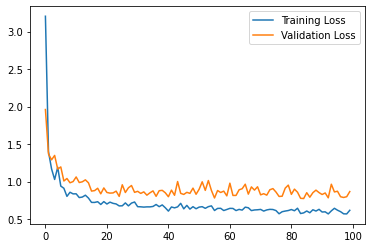

In [21]:
values = new_df_sales_per_day.values

X_train, X_test, y_train, y_test = train_test_split(values[:,:-1], values[:,-1], test_size=0.3, random_state=1)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])) # reshape input
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])) # reshape input

print('Shpe: X_train: ', X_train.shape)
print('Shape Y_train: ', y_train.shape)
print('Shape X_test: ', X_test.shape)
print('Shape Y_test: ', y_test.shape)

# design network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
sgd = optimizers.Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=15, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


The loss looks pretty stable after 60 epochs. This shows that the model converges quickly. Once this step was done, the values ​​for the test data set were estimated.

In [23]:
y_pred = model.predict(X_test) # Predict using the model
print(X_test.shape)

inv_yhat = np.concatenate((y_pred, X_test[:,0, 1:]), axis=1)

inv_xp=inv_yhat[:,1:] #Input

inv_yhat = inv_yhat[:,0] #Output

y_test = y_test.reshape((len(y_test), 1))

inv_y = np.concatenate((y_test, X_test[:,0, 1:]), axis=1)

inv_y = inv_y[:,0] #Output

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(206, 1, 8)
Test RMSE: 1.191


The RMSE for the test data is 1.191. It is important to note that this value may have a little bias since in some cases the amount of data for certain vendor_id is very low.